In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pyhessian import hessian

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = 'mps'

In [4]:
data = pd.read_csv('~/data/MNIST/mnist_train.csv')
test = pd.read_csv('~/data/MNIST/mnist_test.csv')

X = torch.tensor(data.drop('label', axis = 1).to_numpy(), device=device)/255
X_test = torch.tensor(test.drop('label', axis = 1).to_numpy(), device=device)/255

Y_temp = torch.tensor(data['label'].to_numpy(), device=device)
Y = torch.eye(10, device=device)[Y_temp]

Y_temp = torch.tensor(test['label'].to_numpy(), device=device)
Y_test = torch.eye(10, device=device)[Y_temp]

In [5]:
gen = torch.Generator(device=device)
gen.manual_seed(123)

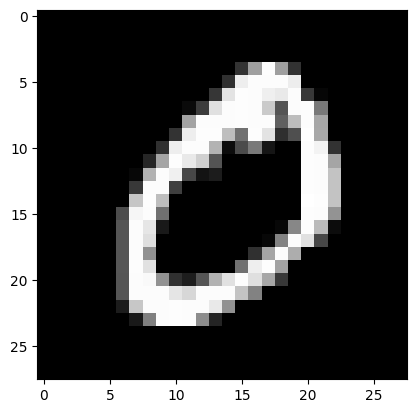

In [6]:
plt.imshow(X[1].view(28,28).cpu(), cmap='gray')

In [7]:
def permut(x):
    perm = np.random.permutation(784)
    x = x[perm]
    return x

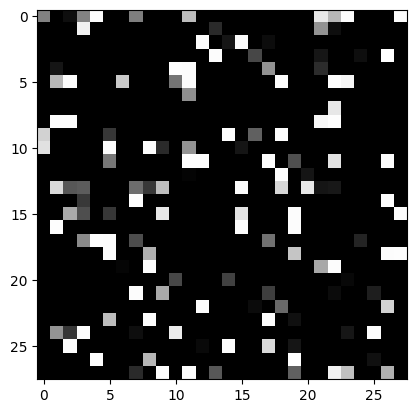

In [8]:
plt.imshow(permut(X[4]).view(28,28).cpu(), cmap='gray')

In [9]:
X_perm = torch.tensor(np.apply_along_axis(permut, axis = 1, arr=X.cpu())).to(device)
X_test_perm = torch.tensor(np.apply_along_axis(permut, axis = 1, arr=X_test.cpu())).to(device)

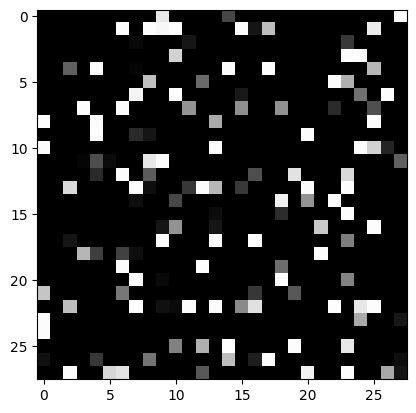

In [10]:
plt.imshow(X_perm[4].cpu().view(28,28), cmap='gray')

In [11]:
from torchsummary import summary

class MLP(nn.Module):
    """Standard MLP"""
    def __init__(self, w, L):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, w)
        self.body = nn.Linear(w,w)
        self.fc2 = nn.Linear(w, 10)
        self.relu = nn.ReLU()
        self.L = L

    def forward(self, x):
        x = self.fc1(x)
        for i in range(self.L):
            x = self.body(x)
        x = self.fc2(x)

        return x
    
mlp = MLP(100, 5)
summary(mlp, (1,784))
mlp = mlp.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
            Linear-2               [-1, 1, 100]          10,100
            Linear-3               [-1, 1, 100]          10,100
            Linear-4               [-1, 1, 100]          10,100
            Linear-5               [-1, 1, 100]          10,100
            Linear-6               [-1, 1, 100]          10,100
            Linear-7                [-1, 1, 10]           1,010
Total params: 130,010
Trainable params: 130,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.50
Estimated Total Size (MB): 0.50
----------------------------------------------------------------


In [12]:
optimizer = torch.optim.SGD(mlp.parameters(), lr=2/1)

In [16]:
def top_eigen(model, loss, X, Y, prt=False):

    model.eval()
    hess_comp = hessian(model, loss, (X,Y) )

    top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
    if prt: 
        print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[-1])
        
    model.train()
    return top_eigenvalues[-1]

from hessian_eigenthings import compute_hessian_eigenthings
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, Y)

train_dataloader = DataLoader( dataset, batch_size=4096, shuffle=True)

In [17]:
MSE = nn.MSELoss()

top_eigen(mlp, MSE , X, Y, prt=True)

eigenvals, eigenvecs = compute_hessian_eigenthings(mlp, train_dataloader, MSE, 1, power_iter_steps=5)

print(eigenvals)

The top Hessian eigenvalue of this model is 0.6872
 [====================================================>............]  Step: 1s587ms | Tot: 6s331ms | power iter error: 0.14 5/5 5 
[0.52493823]


In [18]:
loss_hist = []
lam = []

for epoch in range(700):

        running_loss = 0.0
        for x, y in train_dataloader:

            optimizer.zero_grad()
            # Training
            out = mlp(x)
            
            loss = MSE(out, y)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            lam.append(top_eigen(mlp, MSE, x, y))
            loss_hist.append(loss.item())

print('Finished Training')

acc = []
acc.append( torch.sum(torch.argmax(mlp(X_test), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test) )

KeyboardInterrupt: 

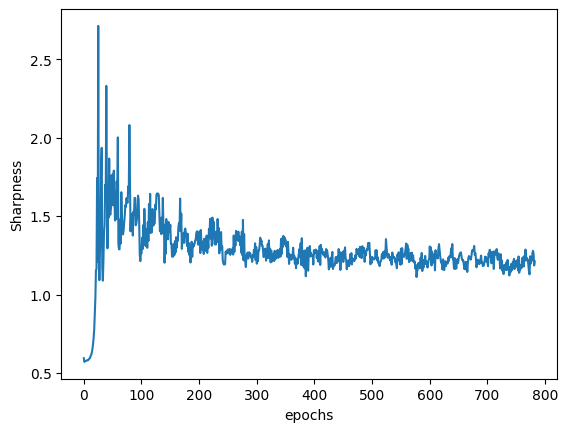

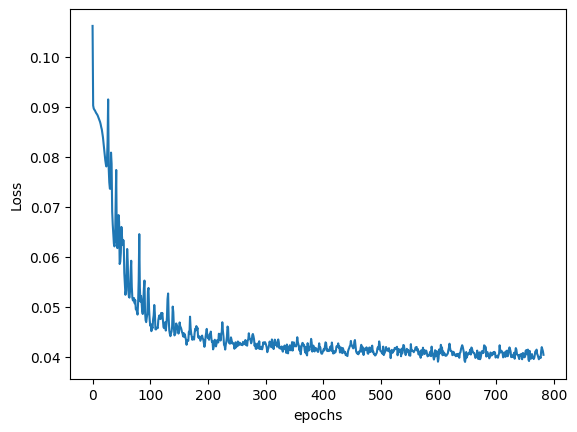

In [19]:
plt.plot(lam)
plt.xlabel('epochs')
plt.ylabel('Sharpness')
plt.show()

plt.plot(loss_hist)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

In [20]:
hess_comp = hessian( mlp, MSE, (X,Y) )
top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[0])

eigenvals, eigenvecs = compute_hessian_eigenthings(mlp, train_dataloader, MSE, 1, power_iter_steps=10)

print(eigenvals)

The top Hessian eigenvalue of this model is 1.1941
 [==========================================================>......]  Step: 1s611ms | Tot: 14s234ms | power iter error: 0.00 10/10  
[1.10082579]


In [35]:
hess_comp = hessian(mlp, MSE, (X_perm,Y) )
top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
print("The top Hessian eigenvalue of this model is %.4f", top_eigenvalues[0])

The top Hessian eigenvalue of this model is %.4f 1.4335412979125977


In [ ]:
batch = len(X)
loss_eval = 100

for epoch in range(700):

        running_loss = 0.0
        for i in range(len(X)//batch):

            # Batch of training 
            ix = torch.randint(0, len(X), (batch,), generator=gen, device=device)
            ixc = torch.randint(0, len(X), (1024,), generator=gen, device=device)

            # Training
            out = mlp(X_perm[ix])
            loss = MSE(out, Y[ix])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            lam.append(top_eigen(mlp, MSE, X_perm[ixc],Y[ixc]))
            loss_hist.append(loss.item())

            if i % loss_eval == loss_eval-1:
                print(f'(epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {running_loss/loss_eval:.2f}')
                running_loss = 0.0

print('Finished Training')

acc.append( torch.sum(torch.argmax(mlp(X_test), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test) )

In [ ]:
plt.plot(lam)
plt.xlabel('epochs')
plt.ylabel('Sharpness')
plt.show()

plt.plot(loss_hist)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
acc

In [ ]:
torch.sum(torch.argmax(mlp(X_test_perm), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test)